In [1]:
# Created on 11/11/22 at 2:57 PM


'''
this script load all the behavioral data saved under
/eeg-behavior/combined/
and make plots and predictions
'''

#%%
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import interactive
interactive(True)
import pandas as pd
import numpy as np
import os
import hdf5storage
import random
from sklearn.metrics import r2_score
import pickle
import matplotlib
from matplotlib.gridspec import GridSpec
from scipy.io import savemat
import shutil
import os
from configparser import ConfigParser
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import time

from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import timeop
plt.rcParams.update({'font.size': 18})
colors = sns.color_palette("deep")
sns.set(style="whitegrid")
# local pacakges


import utils.movingAverage
from utils.movingAverage import *




In [2]:
# load data


#%%
# Author: Jenny Sun
# chop the data such that we have
# identify the frame where peak evidence occur

def loadsubjdict(fnames):
    datadict = hdf5storage.loadmat(fnames)
    return datadict

cond = 100

projectdir = '/home/jenny/evidence-chain/'
filename='/ssd/rwchain-all/round2/rwchain-beh/combined/all_' + str(cond) + '.mat'
datadict = hdf5storage.loadmat(filename)


masktrial = datadict['masktrial']
respall = datadict['resp']
sequenceall = datadict['sequence']
rtall = datadict['rt']
sidall = datadict['sidall']



cumsum = np.cumsum(sequenceall, axis=1)
rtadjusted = rtall-300
count = np.zeros_like(rtall)
val, m = divmod(rtadjusted, cond)
count[m==0] =val[m==0]   # it's exacly at the onset of the new stimulus,
                        # we say they made a decisiona after seeing th previous ones
count[m>0] = val[m>0] + 1  # so, count it the last display that would count
                            # count =3 means they have seen display 0, 1, 2.

count[count>=30] = 30

# calculate first occurence of max evidene
maxval = []
maxind = []
sequence_stopAll = []
bound = []
boundind = []
nummax = []
for c in range(cumsum.shape[0]):
    sequence_stop = cumsum[c, :int(count[c])]   # for example, if rt adjusted i 708, for 250ms, one have seen 3 stimulus.
    sequence_stopAll.append(sequence_stop)
    bound.append(sequence_stop[-1])
    boundind.append(len(sequence_stop)-1)
    maxindtrial = np.where(np.abs(sequence_stop) ==np.max(abs(sequence_stop)))[0]
    maxind.append(maxindtrial)
    maxval.append(sequence_stop[maxindtrial])
    nummax.append(len(maxindtrial))




In [3]:
# calculate the first and last peak evidence timing and value
boundind = np.array(boundind)
maxfirst = np.array([f[0] for f in maxind])
maxlast = np.array([f[-1] for f in maxind])
maxvallast = np.array([f[-1] for f in maxval])
maxvalfirst =  np.array([f[0] for f in maxval])
nummax = np.array([i.shape[0] for i in maxind])
bound = np.array(bound)
offsetfirst = boundind-np.array(maxfirst)
offsetlast = boundind-np.array(maxlast)
acc = np.zeros_like(rtall, dtype='bool')
acc[(bound>=0) & (respall >0)] = 1
acc[(bound<=0) & (respall <0)] = 1

/home/jenny/anaconda3/envs/echain/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


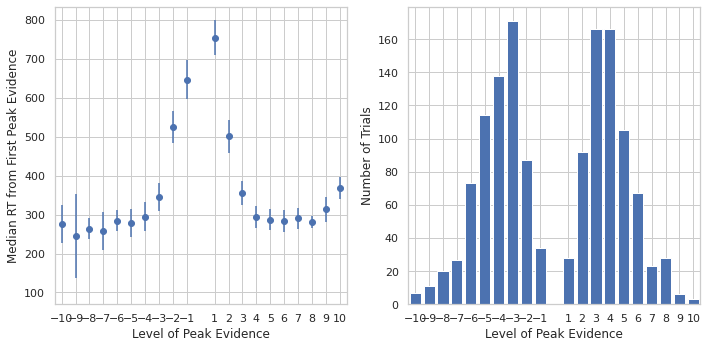

In [4]:
# Plotting first peak evidence sets of plots

fig, ax = plt.subplots(1,2,figsize= (10,5))
df_PeakToRT = pd.DataFrame({'peakLevel': maxvalfirst[acc],
             'PeakToRT':rtall[acc]- (maxfirst[acc] + 1) * cond},columns=['peakLevel','PeakToRT'])

out = df_PeakToRT.groupby('peakLevel')

xlabel = out.count().index
# ax.scatter(xlabel, out.mean())
errorbars = (out.std().to_numpy()).squeeze() / np.sqrt((out.size().to_numpy()).squeeze())
ax[0].errorbar(xlabel.to_numpy(),out.median().to_numpy(), np.nan_to_num(errorbars),fmt='o')
ax[0].set_xticks(xlabel)
ax[0].set_xlim(-10.5,10.5)
ax[0].set_ylabel('Median RT from First Peak Evidence')
ax[0].set_xlabel('Level of Peak Evidence')

ax[1].bar(xlabel.to_numpy(), out.size().to_numpy())
ax[1].set_xticks(xlabel)
ax[1].set_xlim(-10.5,10.5)
ax[1].set_ylabel('Number of Trials')
ax[1].set_xlabel('Level of Peak Evidence')
fig.tight_layout()
fig.show()


/home/jenny/anaconda3/envs/echain/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


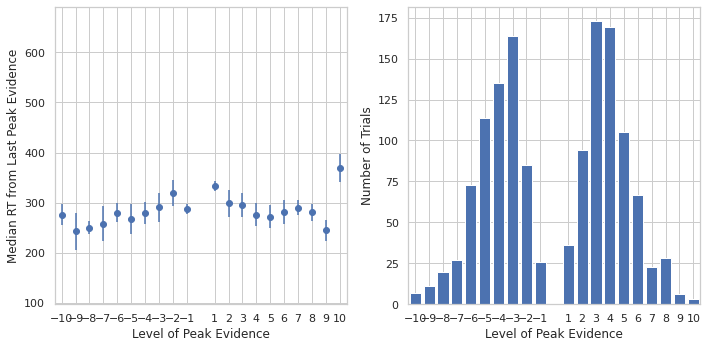

In [5]:
fig, ax = plt.subplots(1,2,figsize= (10,5))

df_PeakToRTLast = pd.DataFrame({'peakLevel': maxvallast[acc],
             'PeakToRT':rtall[acc]- (maxlast[acc] + 1) * cond},columns=['peakLevel','PeakToRT'])

outLast = df_PeakToRTLast.groupby('peakLevel')

xlabel = outLast.count().index
# ax.scatter(xlabel, out.mean())
errorbars = (outLast.std().to_numpy()).squeeze() / np.sqrt((outLast.size().to_numpy()).squeeze())
ax[0].errorbar(xlabel.to_numpy(),outLast.median().to_numpy(), np.nan_to_num(errorbars),fmt='o')
ax[0].set_xticks(xlabel)
ax[0].set_xlim(-10.5,10.5)
ax[0].set_ylabel('Median RT from Last Peak Evidence')
ax[0].set_xlabel('Level of Peak Evidence')

ax[1].bar(xlabel.to_numpy(), outLast.size().to_numpy())
ax[1].set_xticks(xlabel)
ax[1].set_xlim(-10.5,10.5)
ax[1].set_ylabel('Number of Trials')
ax[1].set_xlabel('Level of Peak Evidence')
fig.tight_layout()
fig.show()


/home/jenny/anaconda3/envs/echain/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


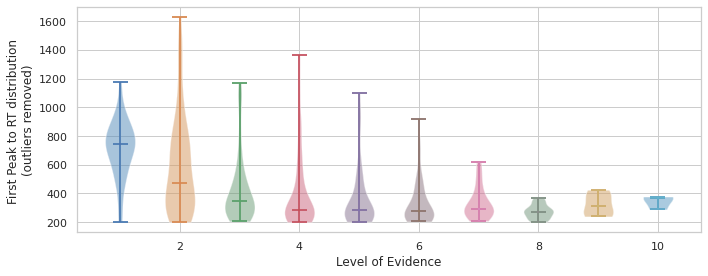

In [6]:


fig, ax = plt.subplots(1,1,figsize= (10,4))
for i, k in enumerate(out.groups.keys()):
    if np.abs(k) <=10 and np.abs(k)>=1:
        rtLevel = df_PeakToRT['PeakToRT'][out.groups[np.abs(k)]]
        sortRT = rtLevel[rtLevel <= (rtLevel.mean() + rtLevel.std() *2.5)]
        v = ax.violinplot(sortRT, 
        positions = [np.abs(k)], showmedians=True)
ax.set_xlabel('Level of Evidence')
ax.set_ylabel('First Peak to RT distribution \n(outliers removed)')
fig.tight_layout()
fig.show()



/home/jenny/anaconda3/envs/echain/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


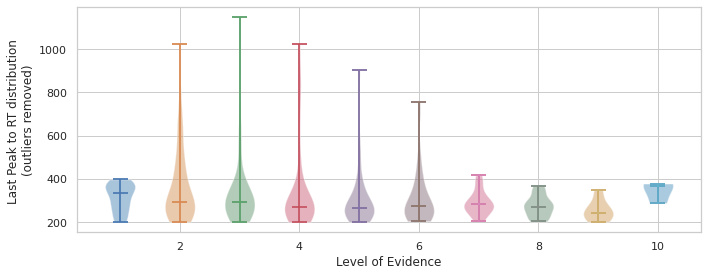

In [7]:


fig, ax = plt.subplots(1,1,figsize= (10,4))
for i, k in enumerate(outLast.groups.keys()):
    if np.abs(k) <=10 and np.abs(k)>=1:
        rtLevel = df_PeakToRTLast['PeakToRT'][outLast.groups[np.abs(k)]]
        sortRT = rtLevel[rtLevel <= (rtLevel.mean() + rtLevel.std() *2.5)]
        v = ax.violinplot(sortRT, 
        positions = [np.abs(k)], showmedians=True)
ax.set_xlabel('Level of Evidence')
ax.set_ylabel('Last Peak to RT distribution \n(outliers removed)')
fig.tight_layout()
fig.show()


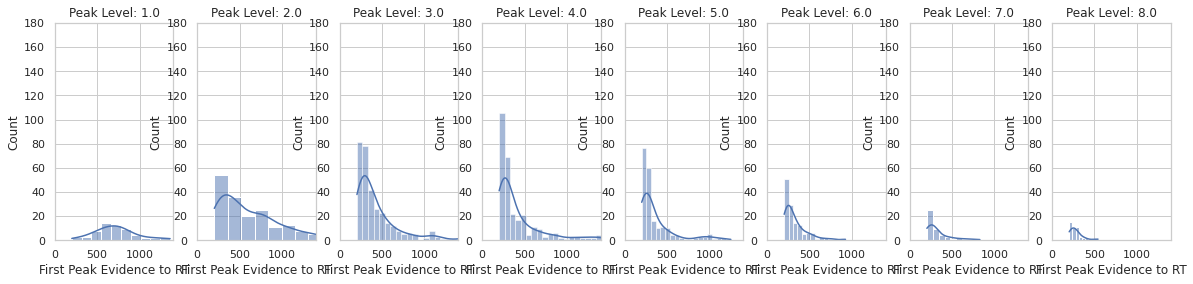

In [8]:

fig, ax = plt.subplots(1, 8, figsize=(20, 4))
ax = ax.reshape(-1)

for i, k in enumerate(out.groups.keys()):
       if (k) >= -8 and (k) <=0:
        count = np.abs(int(k)) - 1
        rtLevel = pd.concat([df_PeakToRT['PeakToRT'][out.groups[k]], df_PeakToRT['PeakToRT'][out.groups[-k]]])
        rtLevel = rtLevel[rtLevel<= (rtLevel.mean() + rtLevel.std()*2.5)]
        v = sns.histplot(rtLevel, kde =True, ax  = ax[count])
        ax[count].set_xlim(0,1400)
        ax[count].set_ylim(0,180)
        ax[count].set_title('Peak Level: %s'%-k)
        ax[count].set_xlabel('First Peak Evidence to RT')
        count +=1


# fig, ax = plt.subplots(1, 8, figsize=(20, 4))
# ax = ax.reshape(-1)

# for i, k in enumerate(out.groups.keys()):
#        if (k) <= 8 and (k) >=0:
#         count = np.abs(int(k)) - 1
#         v = sns.histplot(df_PeakToRT['PeakToRT'][out.groups[k]], kde =True, ax  = ax[count])
#         # ax[count].hist(df_PeakToRT['PeakToRT'][out.groups[k]])
#         ax[count].set_xlim(0,1500)
#         ax[count].set_ylim(0,80)
#         ax[count].set_title('Peak Level: %s'%k)
#         ax[count].set_xlabel('Peak Evidence to RT')
#         count +=1

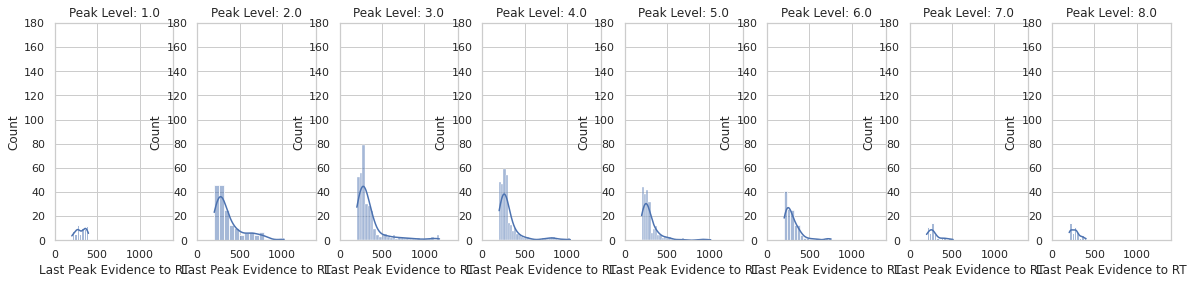

In [9]:

fig, ax = plt.subplots(1, 8, figsize=(20, 4))
ax = ax.reshape(-1)

for i, k in enumerate(outLast.groups.keys()):
       if (k) >= -8 and (k) <=0:
        count = np.abs(int(k)) - 1
        rtLevel = pd.concat([df_PeakToRTLast['PeakToRT'][outLast.groups[k]], df_PeakToRTLast['PeakToRT'][outLast.groups[-k]]])
        rtLevel = rtLevel[rtLevel<= (rtLevel.mean() + rtLevel.std()*2.5)]
        v = sns.histplot(rtLevel, kde =True, ax  = ax[count])
        ax[count].set_xlim(0,1400)
        ax[count].set_ylim(0,180)
        ax[count].set_title('Peak Level: %s'%-k)
        ax[count].set_xlabel('Last Peak Evidence to RT')
        count +=1

IndexError: invalid index to scalar variable.

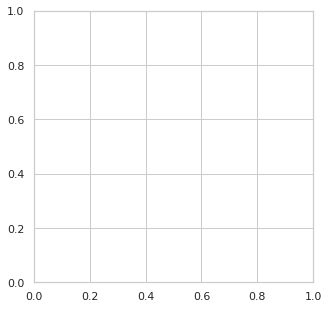

In [10]:

# all subject plot
#######################  Boundary at response ###############################
subind = np.ones_like(sidall,dtype='bool')

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colors = sns.color_palette("Paired")
subound = bound[subind]
subresp = respall[subind]
# boundary as a function of count
import pandas as pd
acc = np.zeros_like(rtall, dtype='bool')
acc[(bound>=0) & (respall >0)] = 1
acc[(bound<=0) & (respall <0)] = 1

df = pd.DataFrame({'boundary': np.abs(subound[acc]), 'count':count[acc]},columns=['boundary', 'count'])
out = df.groupby('count')
bmean = out.mean()
boundmean = np.array(bmean['boundary'])
n=1
bmeanbin = np.average(boundmean.reshape(-1, n), axis=1)
ax.plot(1+np.arange(0,len(bmeanbin)*n,n), bmeanbin,color = 'grey')
ax.set_xticks(1+np.arange(0,len(bmeanbin)*n,4))
movingAverageWindow = 3
bmeanMovingAverage = getMovingAverage(bmeanbin,movingAverageWindow)
ax.plot(1+np.arange(0,len(bmeanbin),len(bmeanbin)/len(bmeanMovingAverage)), bmeanMovingAverage, linewidth = 7, color= 'purple', alpha = 0.8,\
           label = 'Human Data (Moving Average window = %s)'%movingAverageWindow)
ax.set_xlabel('Number of samples seen')
ax.set_ylabel('Boundary Mean')
fig.suptitle('Level of Evidence (Boundary) at Response (ISI: %s ms)'%str(cond))
ax.legend()


[1.7268518518518519, 2.357103952692188, 2.86447540181121, 2.9297739092738966, 3.098372383146204, 3.1244701830927615, 3.4149409063993055, 3.616090331686662, 3.813098548038307, 3.756932491872251, 3.9668090350821275, 3.9155531641407344, 4.14094998953756, 3.822546314544738, 3.84702842377261, 3.891472868217054, 4.217391304347826, 5.116381203337725, 5.057901671173982, 5.17384370015949, 4.598086124401914, 4.934343434343435, 5.6565656565656575, 5.64957264957265, 5.689255189255189, 5.10989010989011, 5.238095238095238, 5.038095238095238]


/home/jenny/anaconda3/envs/echain/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


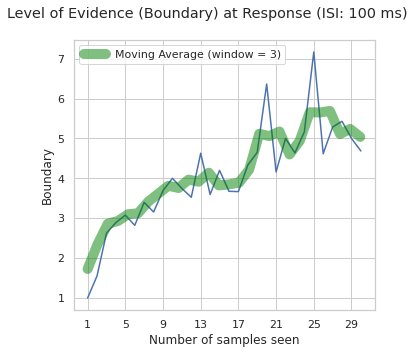

In [11]:
#%%
# Author: Jenny Sun
# chop the data such that we have
# identify the frame where peak evidence occur

def loadsubjdict(fnames):
    datadict = hdf5storage.loadmat(fnames)
    return datadict

cond = 100

projectdir = '/home/jenny/evidence-chain/'
filename='/ssd/rwchain-all/round2/rwchain-beh/combined/all_' + str(cond) + '.mat'
datadict = hdf5storage.loadmat(filename)


masktrial = datadict['masktrial']
respall = datadict['resp']
sequenceall = datadict['sequence']
rtall = datadict['rt']
sidall = datadict['sidall']



cumsum = np.cumsum(sequenceall, axis=1)
rtadjusted = rtall-300
count = np.zeros_like(rtall)
val, m = divmod(rtadjusted, cond)
count[m==0] =val[m==0]   # it's exacly at the onset of the new stimulus,
                        # we say they made a decisiona after seeing th previous ones
count[m>0] = val[m>0] + 1  # so, count it the last display that would count
                            # count =3 means they have seen display 0, 1, 2.

count[count>=30] = 30

# calculate first occurence of max evidene
maxval = []
maxind = []
sequence_stopAll = []
bound = []
boundind = []
nummax = []
for c in range(cumsum.shape[0]):
    sequence_stop = cumsum[c, :int(count[c])]   # for example, if rt adjusted i 708, for 250ms, one have seen 3 stimulus.
    sequence_stopAll.append(sequence_stop)
    bound.append(sequence_stop[-1])
    boundind.append(len(sequence_stop)-1)
    maxindtrial = np.where(np.abs(sequence_stop) ==np.max(abs(sequence_stop)))[0]
    maxind.append(maxindtrial)
    maxval.append(sequence_stop[maxindtrial])
    nummax.append(len(maxindtrial))

boundind = np.array(boundind)
maxfirst = np.array([f[0] for f in maxind])
maxlast = np.array([f[-1] for f in maxind])
maxvallast = np.array([f[-1] for f in maxval])
maxvalfirst =  np.array([f[0] for f in maxval])
nummax = np.array([i.shape[0] for i in maxind])
bound = np.array(bound)
offsetfirst = boundind-np.array(maxfirst)
offsetlast = boundind-np.array(maxlast)



# all boundaries######
subind = np.ones_like(sidall,dtype='bool')

# # rt distribution
sns.set(style="whitegrid")
# fig, ax = plt.subplots(2,1, figsize= (6,6))
# ax = ax.flatten()
# # sns.histplot(rtall, ax= ax[0])
# # ax[0].set_title('RT distribution')
# sns.histplot(nummax,discrete=True, ax= ax[0],color = colors[2])
# ax[0].set_title('num of peak evidence samples \nprior to decision')
# # sns.histplot(maxvallast,discrete=True, ax= ax[2])
# sns.histplot(maxvalfirst,discrete=True, ax= ax[1], color = colors[2])
# ax[1].set_title('Distribution of Value of Last Peak Evidence ')
# fig.tight_layout()
# fig.show()




#%%
# all subject plot
#  Boundary at response
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
colors = sns.color_palette("Paired")
subound = bound[subind]
subresp = respall[subind]



# boundary as a function of count
acc = np.zeros_like(rtall, dtype='bool')
acc[(bound>=0) & (respall >0)] = 1
acc[(bound<=0) & (respall <0)] = 1
df = pd.DataFrame({'boundary': np.abs(subound[acc]), 'count':count[acc]},columns=['boundary', 'count'])
out = df.groupby('count')
bmean = out.mean()
boundmean = np.array(bmean['boundary'])
n=1
bmeanbin = np.average(boundmean.reshape(-1, n), axis=1)
ax.plot(1+np.arange(0,len(bmeanbin)*n,n), bmeanbin)
ax.set_xticks(1+np.arange(0,len(bmeanbin)*n,4))
movingAverageWindow = 3
bmeanMovingAverage = getMovingAverage(bmeanbin,movingAverageWindow)
ax.plot(1+np.arange(0,len(bmeanbin),len(bmeanbin)/len(bmeanMovingAverage)), bmeanMovingAverage, linewidth = 10, color= 'green', alpha = 0.5,\
           label = 'Moving Average (window = %s)'%movingAverageWindow)
levels = np.arange(1,31)

ax.set_xlabel('Number of samples seen')
ax.set_ylabel('Boundary')
fig.suptitle('Level of Evidence (Boundary) at Response (ISI: %s ms)'%str(cond))
ax.legend()
fig.show()
fig.tight_layout()
fig.savefig(projectdir +'plots/boundall_%s.png'%str(cond))

[1.7268518518518519, 2.357103952692188, 2.86447540181121, 2.9297739092738966, 3.098372383146204, 3.1244701830927615, 3.4149409063993055, 3.616090331686662, 3.813098548038307, 3.756932491872251, 3.9668090350821275, 3.9155531641407344, 4.14094998953756, 3.822546314544738, 3.84702842377261, 3.891472868217054, 4.217391304347826, 5.116381203337725, 5.057901671173982, 5.17384370015949, 4.598086124401914, 4.934343434343435, 5.6565656565656575, 5.64957264957265, 5.689255189255189, 5.10989010989011, 5.238095238095238, 5.038095238095238]


/home/jenny/anaconda3/envs/echain/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


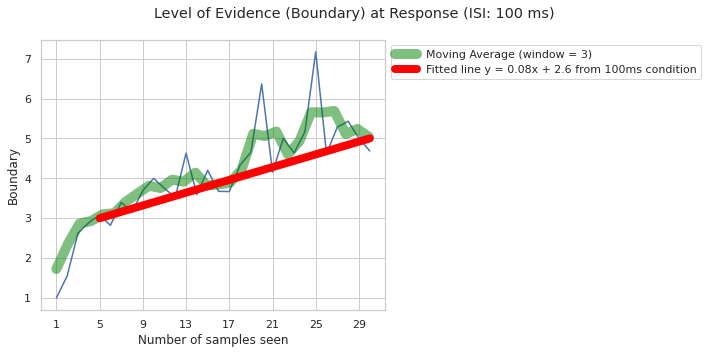

In [12]:


#%%
# all subject plot
#  Boundary at response
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
colors = sns.color_palette("Paired")
subound = bound[subind]
subresp = respall[subind]



# boundary as a function of count
acc = np.zeros_like(rtall, dtype='bool')
acc[(bound>=0) & (respall >0)] = 1
acc[(bound<=0) & (respall <0)] = 1
df = pd.DataFrame({'boundary': np.abs(subound[acc]), 'count':count[acc]},columns=['boundary', 'count'])
out = df.groupby('count')
bmean = out.mean()
boundmean = np.array(bmean['boundary'])
n=1
bmeanbin = np.average(boundmean.reshape(-1, n), axis=1)
ax.plot(1+np.arange(0,len(bmeanbin)*n,n), bmeanbin)


   
ax.set_xticks(1+np.arange(0,len(bmeanbin)*n,4))
movingAverageWindow = 3
bmeanMovingAverage = getMovingAverage(bmeanbin,movingAverageWindow)
ax.plot(1+np.arange(0,len(bmeanbin),len(bmeanbin)/len(bmeanMovingAverage)), bmeanMovingAverage, linewidth = 10, color= 'green', alpha = 0.5,\
           label = 'Moving Average (window = %s)'%movingAverageWindow)
levels = np.arange(1,31)

decayF = np.linspace(1,0.25,27)


possibleAmount = levels *0.5
# ax.plot(levels[3:], possibleAmount[3:], label = 'assuming 50 percent of evidence favors one choice',color ='red')

possibleAmount = levels *0.62 



#define data
x = np.array([5,30])
y = np.array([3,5])

#find line of best fit
a, b = np.polyfit(x, y, 1)
ax.plot(x, a*x+b, color = 'red', linewidth = 8,label = 'Fitted line y = 0.08x + 2.6 from 100ms condition')     
# ax.plot(levels[3:], possibleAmount[3:], label = 'assuming 62 percent of evidence favors one choice',color='purple')

ax.set_xlabel('Number of samples seen')
ax.set_ylabel('Boundary')
fig.suptitle('Level of Evidence (Boundary) at Response (ISI: %s ms)'%str(cond))
ax.legend(bbox_to_anchor = [1,1])
fig.show()
fig.tight_layout()
fig.savefig(projectdir +'plots/boundall_%s.png'%str(cond))

In [32]:
count = 0
# fig, ax = plt.subplots(1, 8, figsize=(25, 4))
ax = ax.reshape(-1)
df_PeakToRT['sampleCounts'] = df['count']
for i, k in enumerate(out.groups.keys()):
       if (k) >= -8 and (k) <=0:
        print(k)
       #  count = np.abs(int(k)) - 1
        rtLevel = pd.concat([df_PeakToRT['PeakToRT'][out.groups[k]], df_PeakToRT['PeakToRT'][out.groups[-k]]])
        outlierInd = rtLevel<= (rtLevel.mean() + rtLevel.std()*2.5)
        rtLevel = rtLevel[outlierInd]
        countLevel = pd.concat([df_PeakToRT['sampleCounts'][out.groups[k]], df_PeakToRT['sampleCounts'][out.groups[-k]]])
        countLevel = countLevel[outlierInd]
        print(rtLevel)
        ax[count].scatter(countLevel,rtLevel,color = 'teal')
        ax[count].set_xlim(0,31)
        ax[count].set_ylim(0,2000)
        ax[count].set_title('Level: %s'%-k)
        ax[count].set_xlabel('First Peak Samples Seen')
        count +=1


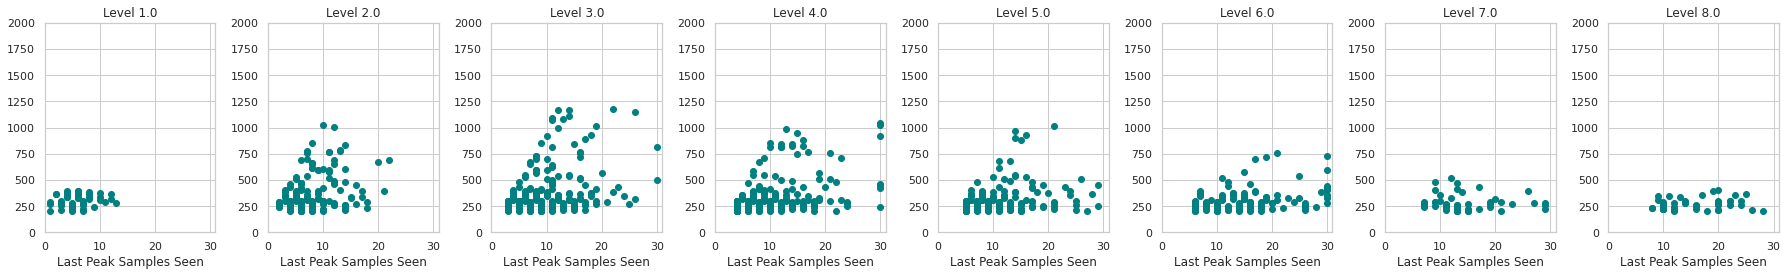

In [28]:
df_PeakToRTLast['sampleCounts'] = df['count']

fig, ax = plt.subplots(1, 8, figsize=(25, 4))
ax = ax.reshape(-1)
df_PeakToRTLast['sampleCounts'] = df['count']
for i, k in enumerate(outLast.groups.keys()):
       if (k) >= -8 and (k) <=0:
        count = np.abs(int(k)) - 1
        rtLevel = pd.concat([df_PeakToRTLast['PeakToRT'][outLast.groups[k]], df_PeakToRTLast['PeakToRT'][outLast.groups[-k]]])
        outlierInd = rtLevel<= (rtLevel.mean() + rtLevel.std()*2.5)
        rtLevel = rtLevel[outlierInd]
        countLevel = pd.concat([df_PeakToRTLast['sampleCounts'][outLast.groups[k]], df_PeakToRTLast['sampleCounts'][outLast.groups[-k]]])
        countLevel = countLevel[outlierInd]
        ax[count].scatter(countLevel,rtLevel,color = 'teal')
        ax[count].set_xlim(0,31)
        ax[count].set_ylim(0,2000)
        ax[count].set_title('Level %s'%-k)
        ax[count].set_xlabel('Last Peak Samples Seen')
        count +=1
fig.tight_layout()

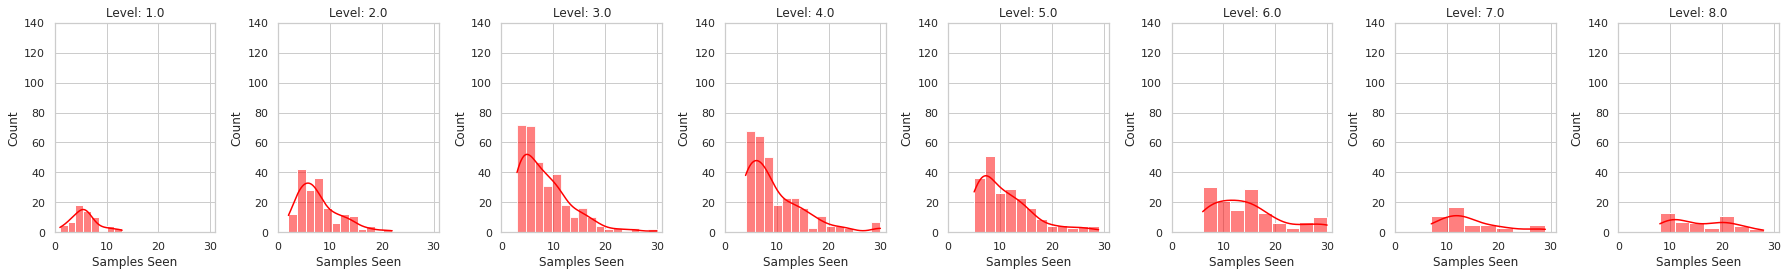

In [18]:

fig, ax = plt.subplots(1, 8, figsize=(25, 4))
ax = ax.reshape(-1)
for i, k in enumerate(outLast.groups.keys()):
       if (k) >= -8 and (k) <=0:
        count = np.abs(int(k)) - 1
        rtLevel = pd.concat([df_PeakToRTLast['PeakToRT'][outLast.groups[k]], df_PeakToRTLast['PeakToRT'][outLast.groups[-k]]])
        outlierInd = rtLevel<= (rtLevel.mean() + rtLevel.std()*2.5)
        rtLevel = rtLevel[outlierInd]
        countLevel = pd.concat([df_PeakToRTLast['sampleCounts'][outLast.groups[k]], df_PeakToRTLast['sampleCounts'][outLast.groups[-k]]])
        countLevel = countLevel[outlierInd]
        v = sns.histplot(countLevel, kde =True, ax  = ax[count],color='red')
        ax[count].set_xlim(0,31)
        ax[count].set_ylim(0,140)
        ax[count].set_title('Level: %s'%-k)
        ax[count].set_xlabel('Samples Seen')
        count +=1
fig.tight_layout()
